### Monthly Air Temperature Anomaly (Ilulissat Mittarfik)

In [2]:
# IMPORT MODULES
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import numpy as np 
import datetime
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

In [3]:
# Open the Ilulissat Weather Station (422100) Data
ilulissat_data = pd.read_csv('R:/JAKOBSHAVN/CODE/github/jakobshavn_isbrae/data/422100_ilulissat_air_temp.csv', sep = ';')

# Define the date and mean air temperature variables, as specified in (https://www.dmi.dk/fileadmin/Rapporter/2023/DMIRep23-08.pdf)
ilulissat_data = ilulissat_data.drop(['Station', '112', '113', '122', '123', '201', '301','305', '365', '371', '401', '504', '550', '601', '603', '609', '801'], axis=1)
ilulissat_data = ilulissat_data.rename(columns={'101': 'mean_air_temp'})
ilulissat_data['Date'] = pd.to_datetime(ilulissat_data[['Year', 'Month', 'Day']]) # Extract the 'Date' from the Year, Month, Day columns
column_order = ['Date', 'Year', 'Month', 'Day', 'Hour(utc)', 'mean_air_temp'] # Define the column order
ilulissat_data = ilulissat_data[column_order]

# Extract the dataframe between 1992 and 2023
ilulissat_data = ilulissat_data.loc[(ilulissat_data['Date'] >= '1992-01-01') & (ilulissat_data['Date'] <= '2023-01-01')]

More recent observations are provided at an hourly resolution, however earlier observations are provided every three hours. To keep the temporal resolution consistent throughout the time series, we therefore sample all data at a three hour resolution.

In [4]:
# To keep the temporal sampling consistent across the time-series, extract observational data every three hours.
selected_hours = [0, 3, 6, 9, 12, 15, 18, 21]
ilulissat_3_hours = ilulissat_data[ilulissat_data['Hour(utc)'].isin(selected_hours)]

# For each given day, count the number of observations available. If there are less than 4 observations on a given day (i.e. 12 hours), delete all data for that given date. 
observations_per_day = ilulissat_3_hours.groupby('Date').size().reset_index(name='Observation Count')
filtered_df = ilulissat_3_hours[ilulissat_3_hours['Date'].isin(observations_per_day[observations_per_day['Observation Count'] >= 4]['Date'])]
deleted_dates_count = len(pd.unique(ilulissat_3_hours['Date'])) - len(pd.unique(filtered_df['Date']))
print(f'Total number of deleted dates with < 4 daily observations: {deleted_dates_count}')

Total number of deleted dates with < 4 daily observations: 53


In [5]:
# For all days with more than 4 observations, calculate the mean daily temperature.
filtered_df.set_index('Date', inplace=True)
mean_air_temp_daily = filtered_df.resample('D').mean()
mean_air_temp_daily = mean_air_temp_daily[['mean_air_temp']].reset_index()
print(mean_air_temp_daily.head())

        Date  mean_air_temp
0 1992-01-01     -19.100000
1 1992-01-02     -23.157143
2 1992-01-03     -21.962500
3 1992-01-04     -19.514286
4 1992-01-05     -18.737500


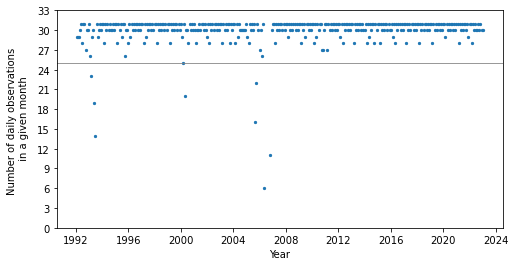

Number of months with less than 25 observations: 8

   Year  Month  No_daily_obs  mean_air_temp       Date
0  1992      1            29     -12.662746 1992-01-01
1  1992      2            29     -26.664183 1992-02-01
2  1992      3            29     -23.227118 1992-03-01
3  1992      4            30     -11.580774 1992-04-01
4  1992      5            31      -4.835445 1992-05-01


In [6]:
# Using the daily mean air temperature dataframe, calculate the number of observations within a given month
mean_air_temp_daily['Year'] = mean_air_temp_daily['Date'].dt.year
mean_air_temp_daily['Month'] = mean_air_temp_daily['Date'].dt.month
mean_air_temp_daily = mean_air_temp_daily.dropna()
monthly_counts = mean_air_temp_daily.groupby(['Year', 'Month']).size().reset_index(name='No_daily_obs')

# Plot the number of observations within a given month
plt.figure(figsize=(8, 4))
plt.scatter(monthly_counts['Year'] + monthly_counts['Month'] / 12, monthly_counts['No_daily_obs'], marker='o', s=5)
plt.xlabel('Year')
plt.ylabel('Number of daily observations \n in a given month', labelpad=8)
plt.xticks(range(1992, 2025, 4)) 
plt.yticks(range(0, 34, 3)) 
plt.axhline(y=25, color='gray', linestyle='-', linewidth=0.8) # Add a horizontal line at 25
plt.show()

# Count and print the number of months with less than 25 daily observations. 
less_than_25_obs_months = monthly_counts[monthly_counts['No_daily_obs'] < 25]
print(f"Number of months with less than 25 observations: {len(less_than_25_obs_months)}")
print() 

# Calculate the mean monthly air temperature. Delete any months that have less than 25 daily observations.
mean_air_temp_monthly = mean_air_temp_daily.groupby(['Year', 'Month'])['mean_air_temp'].mean().reset_index()
mean_air_temp_monthly = pd.merge(monthly_counts, mean_air_temp_monthly, on=['Year', 'Month'])
mean_air_temp_monthly = mean_air_temp_monthly[mean_air_temp_monthly['No_daily_obs'] >= 25]
mean_air_temp_monthly['Date'] = pd.to_datetime(mean_air_temp_monthly[['Year', 'Month']].assign(DAY=1))
print(mean_air_temp_monthly.head())


In [7]:
# Extract dataframes of daily mean temperatures for 1992-2018 and 2018-2023. 
ilulissat_1992_2018_monthly = mean_air_temp_monthly.loc[(mean_air_temp_monthly['Date'] >= '1992-01-01') & (mean_air_temp_daily['Date'] <= '2018-01-01')]
ilulissat_2018_2023_monthly = mean_air_temp_monthly.loc[(mean_air_temp_monthly['Date'] >= '2018-01-01') & (mean_air_temp_daily['Date'] <= '2023-01-01')]

# For the period 1992-2018, calculate the mean temperature for each month across all years. 
ilulissat_1992_2018_monthly_mean = ilulissat_1992_2018_monthly.groupby('Month')['mean_air_temp'].mean().reset_index()

# For the period 2018-2023, calculate the mean temperature for each month for each given year. 
ilulissat_2018_2023_monthly_mean = ilulissat_2018_2023_monthly.groupby(['Year', 'Month'])['mean_air_temp'].mean().reset_index()

# For the period 2018-2023, calculate the monthly air temperature anomaly relative to the period 1992-2018.
ilulissat_2018_2023_anomaly = pd.merge(ilulissat_2018_2023_monthly_mean, ilulissat_1992_2018_monthly_mean, on='Month', suffixes=('_2018_2023', '_1992_2018'))
ilulissat_2018_2023_anomaly['monthly_temp_anomaly_relative_1992_2018'] = ilulissat_2018_2023_anomaly['mean_air_temp_2018_2023'] - ilulissat_2018_2023_anomaly['mean_air_temp_1992_2018']
ilulissat_2018_2023_anomaly['Date'] = pd.to_datetime(ilulissat_2018_2023_anomaly[['Year', 'Month']].assign(DAY=1))
ilulissat_2018_2023_anomaly.drop(['mean_air_temp_2018_2023', 'mean_air_temp_1992_2018',  'Year', 'Month'], axis=1, inplace=True)
ilulissat_2018_2023_anomaly = ilulissat_2018_2023_anomaly[['Date', 'monthly_temp_anomaly_relative_1992_2018']]
print(ilulissat_2018_2023_anomaly.head())

        Date  monthly_temp_anomaly_relative_1992_2018
0 2018-01-01                                -0.791252
1 2019-01-01                                -1.233763
2 2020-01-01                                -2.886413
3 2021-01-01                                 3.370039
4 2022-01-01                                 2.902700


In [9]:
# Save the monthly air temperature anomaly, relative to the period 1992-2018, to a csv file.
ilulissat_2018_2023_anomaly.to_csv('R:/JAKOBSHAVN/CODE/github/jakobshavn_isbrae/data/422100_ilulissat_air_temp_anomalies.csv', index=False)